# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [4]:
git=GitHub(token,repo_owner,repo_name,branch)
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

# Loading Benchmark

In [6]:
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()
days=(today-start_date).days
remaining=days%500
numbers_of_table=days//500
tickers=Binance.get_market_cap()['Ticker'].iloc[:40].to_list()
temp_end=start_date
scope_prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    scope_prices=scope_prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(remaining))
data=Binance.get_price(tickers,temp_end)
scope_prices=scope_prices.combine_first(data)
scope_prices=scope_prices.sort_index()
scope_prices = scope_prices[~scope_prices.index.duplicated(keep='first')]
scope_prices.index=pd.to_datetime(scope_prices.index)
tickers2=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()
prices=scope_prices[tickers2]
returns=np.log(1+prices.pct_change(fill_method=None))
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

results={}

if 'USDCUSDT' in returns_to_use.columns:
    
    cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

else:

    cash=[]
# gold_positions=np.where(returns_to_use.columns=='GOLD.PA')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}#,
                                                                       ])# {'type': 'eq', 'fun': lambda weights: weights[gold_positions]-0.00}])
        
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass

rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T
rolling_optimization.loc[dates_end[0]]=1/len(dataframe.columns)
rolling_optimization=rolling_optimization.sort_index()

performance_model=pd.DataFrame()

In [7]:
q=rebalanced_dynamic_quantities(dataframe,rolling_optimization.iloc[:-2])
results=q*dataframe

performance_model['Fund']=results.sum(axis=1)
performance_model['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_model_pct=performance_model.copy()
performance_model_pct=performance_model_pct.pct_change(fill_method=None)

# Importing Data

In [9]:
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [10]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [12]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [13]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [14]:
quantities_api=Binance.binance_api.user_asset()

current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [15]:
# trade_history=pd.read_excel('Trades USDT.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))

In [16]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

TRXUSDT 0
BTCUSDT 1
TRXUSDT 2
BNBUSDT 3
ETHUSDT 4
SOLUSDT 5
BNBUSDT 6
USDTTRY 7
JASMYUSDT 8
BNBUSDT 9
BBUSDT 10
USDTTRY 11
BNBUSDT 12
USDTTRY 13
TRXUSDT 14
USDTTRY 15
JASMYUSDT 16
BNBUSDT 17
BBUSDT 18
OMUSDT 19
OMUSDT 20
OMUSDT 21
TRXUSDT 22
BTCUSDT 23
OMUSDT 24
BTCUSDT 25
TRXUSDT 26
TRXUSDT 27
BBUSDT 28
BNBUSDT 29
TRXUSDT 30
BTCUSDT 31
TRXUSDT 32
BTCUSDT 33
MKRUSDT 34
BTCUSDT 35
MKRUSDT 36
EURUSDT 37
EURUSDT 38
BBUSDT 39
BNBUSDT 40
JASMYUSDT 41
PEPEUSDT 42
NOTUSDT 43
NOTUSDT 44
NOTUSDT 45
BBUSDT 46
BBUSDT 47
PEPEUSDT 48
JASMYUSDT 49
BTCUSDT 50
BTCUSDT 51
TRXUSDT 52
BTCUSDT 53
BNBUSDT 54
BTCUSDT 55
BNBUSDT 56
BTCUSDT 57
BNBUSDT 58
BTCUSDT 59
BNBUSDT 60
BTCUSDT 61
BNBUSDT 62
BNBUSDT 63
BTCUSDT 64
BNBUSDT 65
JASMYUSDT 66
JASMYUSDT 67
ENSUSDT 68
ARUSDT 69
BTCUSDT 70
UMAUSDT 71
BTCUSDT 72
UMAUSDT 73
ETHUSDT 74
XRPUSDT 75
BTCUSDT 76
XRPUSDT 77
BTCUSDT 78
NEARUSDT 79
BTCUSDT 80
LPTUSDT 81
BTCUSDT 82
NEARUSDT 83
EURUSDT 84
BTCUSDT 85
INJUSDT 86
BTCUSDT 87
FETUSDT 88
EURUSDT 89
EURUSDT 90
EURU

In [17]:
price

,Date(UTC),Market,Type,Price,Amount,Total,Fee,Fee Coin,Pair Price,Price in USDT,Total in USDT,Pair Quantity
0,2025-08-31 22:32:23,TRXUSDT,BUY,0.342500,200.600000,68.705500,0.000056,BNB,0.342962,0.342500,68.705500,200.600000
1,2025-08-31 22:32:07,BTCUSDT,SELL,109079.990000,0.000630,68.720394,0.000056,BNB,109075.714221,109079.990000,68.720394,0.000630
2,2025-08-31 22:28:53,TRXUSDT,BUY,0.342418,2022.600000,692.574470,0.000569,BNB,0.343100,0.342418,692.574485,2022.600000
3,2025-08-31 22:27:52,BNBUSDT,SELL,867.280000,0.019000,16.478320,0.000014,BNB,866.834667,867.280000,16.478320,0.019000
4,2025-08-31 22:27:32,ETHUSDT,SELL,4462.540000,0.069300,309.254022,0.000254,BNB,4467.496043,4462.540000,309.254022,0.069300
...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024-05-09 22:32:57,TRXEUR,BUY,0.118983,205.828142,25.000000,0.510000,EUR,1.077905,0.128252,26.397894,205.828142
116,2024-05-09 19:36:50,UMAEUR,BUY,3.803499,6.438808,25.000000,0.510000,EUR,1.077517,4.098334,26.388383,6.438808
117,2024-05-06 23:27:11,ETHEUR,BUY,2912.268956,0.008407,25.000000,0.510000,EUR,1.076000,3133.601397,26.344908,0.008407
118,2024-05-06 23:15:38,BTCEUR,BUY,59899.712723,0.000409,25.000000,0.510000,EUR,1.076100,64458.080861,26.353686,0.000409


In [18]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

historical_positions.rename(columns={'TRYUSDT': 'USDTTRY'}, inplace=True)

In [19]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_263884\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [20]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()


USDUSDT not retrieved


In [21]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:80].to_list()

In [22]:
holding=Binance.get_inventory()
last_prices=Binance.get_price(list(q.iloc[-1].keys()))

positions=pd.DataFrame(q.iloc[-1]*last_prices).T
positions['Weights Model']=positions[positions.columns]/positions[positions.columns].sum()

condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
holding_tickers.remove("USDCUSDT")
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,last_book_cost,holding.loc[condition],positions['Weights Model'],realized_pnl],axis=1)
pnl.columns=['Average Cost','Book Cost','Price in USDT','Weights','Weights Model','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Average Cost']=np.nan

pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100
pnl.sort_values(by='Weights',ascending=False).round(4)

,Average Cost,Book Cost,Price in USDT,Weights,Weights Model,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,NaN,2111.4767,2103.6058,0.9999,1.0000,-146.9409,139.07,-7.8709,-0.3728
TRXUSDT,0.2647,872.3899,1106.9881,0.5262,0.5681,-12.2962,234.60,222.3038,10.5284
BTCUSDT,68795.5284,565.5529,917.1797,0.4360,0.4319,13.0697,351.63,364.6997,17.2723
OMUSDT,1.1299,526.3213,79.0937,0.0376,0.0000,0.0000,-447.23,-447.2300,-21.1809
ETHUSDT,3654.5327,0.1328,0.1507,0.0001,0.0000,55.9949,0.02,56.0149,2.6529
JASMYUSDT,0.0303,0.0000,0.0000,0.0000,0.0000,-172.9781,0.00,-172.9781,-8.1923
RNDRUSDT,11.1867,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000
HBARUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000
BCHUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000
XLMUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000


In [23]:
selling_amount=pd.DataFrame()

selling_amount['Portfolio']=pnl['Weights']
selling_amount['Model']=pnl['Weights Model']
selling_amount['Positions']=pnl['Price in USDT']

selling_amount['Model Positions']=selling_amount['Model']*selling_amount.loc['Total','Positions']
selling_amount['Spread']=selling_amount['Model Positions']-selling_amount['Positions']
selling_amount.sort_values(by='Model',ascending=False).round(2)

,Portfolio,Model,Positions,Model Positions,Spread
Total,1.00,1.00,2103.61,2103.61,0.00
TRXUSDT,0.53,0.57,1106.99,1195.01,88.02
BTCUSDT,0.44,0.43,917.18,908.60,-8.58
JASMYUSDT,0.00,0.00,0.00,0.00,0.00
NEARUSDT,0.00,0.00,0.00,0.00,0.00
HBARUSDT,0.00,0.00,0.00,0.00,0.00
BCHUSDT,0.00,0.00,0.00,0.00,0.00
XLMUSDT,0.00,0.00,0.00,0.00,0.00
LINKUSDT,0.00,0.00,0.00,0.00,0.00
ADAUSDT,0.00,0.00,0.00,0.00,0.00


In [24]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [25]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [26]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [27]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')
inventory_weights.pop('USDCUSDT')


if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [28]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [29]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [31]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 23972a16a19d923e72328c05be865bacc896effb)
✅ File pushed/updated successfully!


In [32]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [33]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [34]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [35]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: fad0580ed1111aa6e1fc8cde13fbf69fb3c0fce5)
✅ File pushed/updated successfully!


In [36]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [37]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [38]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()
cols=quantities.columns[quantities.columns!='USDCUSDT']

for col in cols:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index] 

In [39]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [40]:
# pnl_history['Total']

In [41]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [42]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [43]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [44]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in cols:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [45]:
pnl_history['Total']

2024-09-23   -247.226270
2024-09-24   -303.288508
2024-09-25   -320.535015
2024-09-26   -234.835798
2024-09-27   -218.316677
                 ...    
2025-09-18   -289.109802
2025-09-19   -326.915405
2025-09-20   -316.539594
2025-09-21   -334.991908
2025-09-22    163.849097
Name: Total, Length: 365, dtype: float64

<Axes: >

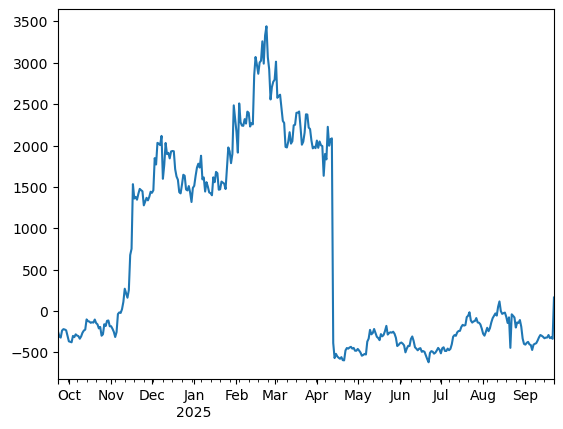

In [46]:
pnl_history['Total'].plot()

In [47]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-31:]

2025-08-23    -17.678735
2025-08-24    -20.768624
2025-08-25   -121.271345
2025-08-26     62.086247
2025-08-27     -5.984666
2025-08-28     34.510654
2025-08-29    -80.680751
2025-08-30   -142.309648
2025-08-31    -64.917376
2025-09-01     -9.128634
2025-09-02     21.807289
2025-09-03     11.513615
2025-09-04    -30.406007
2025-09-05     -7.870188
2025-09-06    -59.574293
2025-09-07     64.103747
2025-09-08     10.429624
2025-09-09      7.514311
2025-09-10     32.069894
2025-09-11     38.330067
2025-09-12     28.157845
2025-09-13     -9.210608
2025-09-14    -12.518451
2025-09-15    -17.024334
2025-09-16      7.182172
2025-09-17      1.849051
2025-09-18     29.806058
2025-09-19    -37.805603
2025-09-20     10.375811
2025-09-21    -18.452314
2025-09-22    498.841005
Name: Total, dtype: float64

In [48]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']

var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-370.2548821800962, -950.5160328166937)

In [49]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [50]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [51]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [52]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [53]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [54]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [55]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

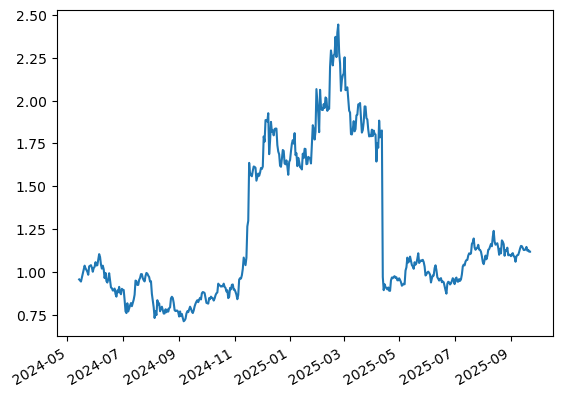

In [56]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

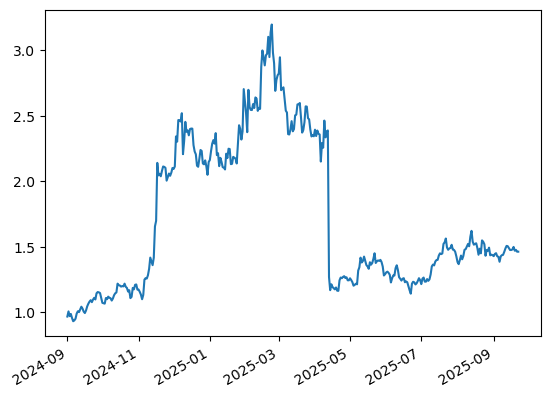

In [57]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [59]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [62]:
days=120
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [63]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [66]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.8027
TRXUSDT,0.1973
WBETHUSDT,0.0000


In [67]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.802712
TRXUSDT,0.197288


In [68]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))

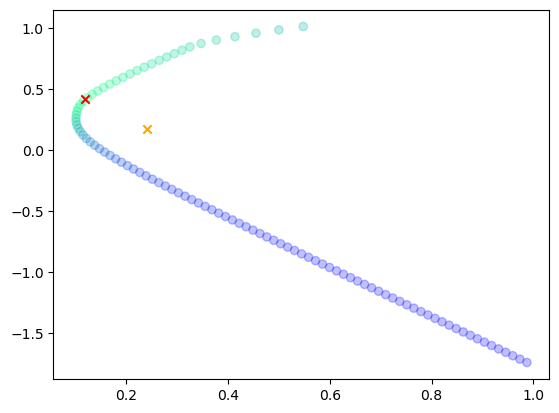

In [69]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [70]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [71]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
TRXUSDT,1106.9881,0.5262,0.0423,0.4839
BTCUSDT,917.1797,0.4360,0.0000,0.4360
OMUSDT,79.0937,0.0376,0.0000,0.0376
ETHUSDT,0.1507,0.0001,0.0000,0.0001
SOLUSDT,0.0952,0.0000,0.0000,0.0000
BNBUSDT,0.0652,0.0000,0.1253,-0.1253
USDCUSDT,0.0332,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
PAXGUSDT,0.0000,0.0000,0.6648,-0.6648


### Current results

In [73]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [74]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BNBUSDT,0.802911
TRXUSDT,0.197089


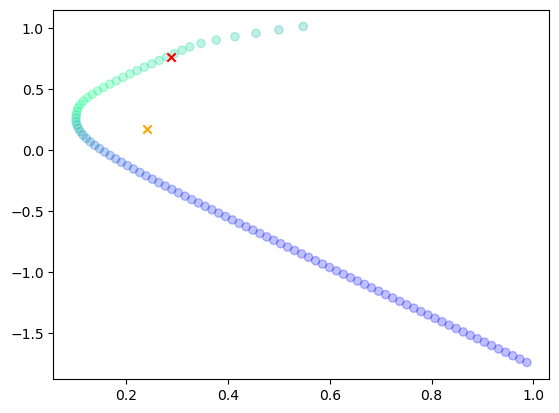

In [75]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [76]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
TRXUSDT,1106.9881,0.5262,0.1971,0.3291
BTCUSDT,917.1797,0.4360,0.0000,0.4360
OMUSDT,79.0937,0.0376,0.0000,0.0376
ETHUSDT,0.1507,0.0001,0.0000,0.0001
SOLUSDT,0.0952,0.0000,0.0000,0.0000
BNBUSDT,0.0652,0.0000,0.8029,-0.8029
USDCUSDT,0.0332,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000


# Risk Reward Analysis

In [78]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [79]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
portfolio_perf['Model']=performance_model_pct['Fund']

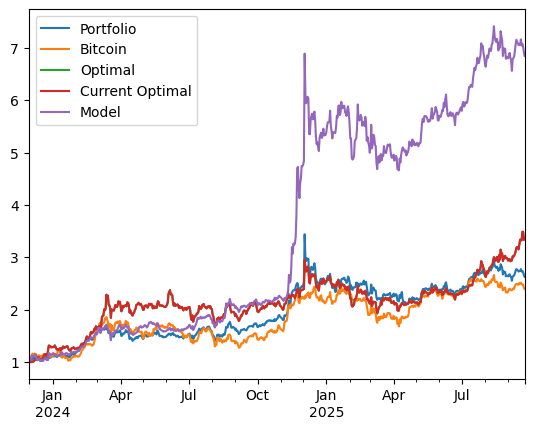

In [80]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [81]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

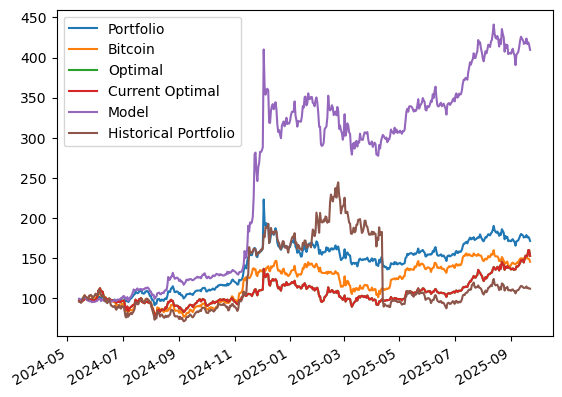

In [82]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


<Axes: >

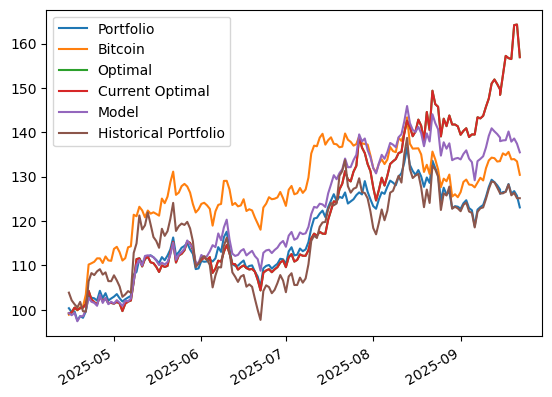

In [83]:
((1+current_perf.loc['2025-04-15':]).cumprod()*100).plot()

<Axes: >

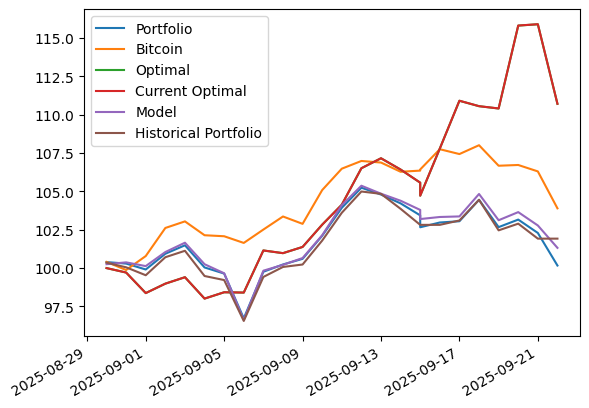

In [84]:
((1+current_perf.loc['2025-08-30':]).cumprod()*100).plot()

In [85]:
((1+current_perf.loc['2025-08-30':]).cumprod()*100)

,Portfolio,Bitcoin,Optimal,Current Optimal,Model,Historical Portfolio
2025-08-30,100.391998,100.404183,100.001188,100.001152,100.256523,100.353789
2025-08-31,100.295790,99.876884,99.711130,99.710877,100.375068,100.051951
2025-09-01,99.909757,100.787165,98.371559,98.371246,100.131022,99.535062
2025-09-02,100.937378,102.618109,98.986923,98.986703,101.048870,100.710311
2025-09-03,101.487997,103.046817,99.406431,99.406133,101.656804,101.129679
2025-09-04,100.042789,102.143595,98.012025,98.011824,100.253501,99.485482
2025-09-05,99.644450,102.078191,98.425152,98.425293,99.663249,99.220782
2025-09-06,96.724434,101.641846,98.403737,98.405142,96.614945,96.554921
2025-09-07,99.761697,102.513832,101.150573,101.151436,99.832474,99.424509
2025-09-08,100.237604,103.366171,100.974638,100.975449,100.211609,100.075140


## Volatilities

In [87]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.288732
 dtype: float64,
 0.2887318681264896)

In [88]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.240067
 dtype: float64,
 0.24006711748104423)

In [89]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.400261
Bitcoin            0.400057
Optimal            0.405360
Current Optimal    0.405377
Model              0.488047
dtype: float64

In [90]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.19589296660401645

In [91]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-0.958693870252937

<Axes: >

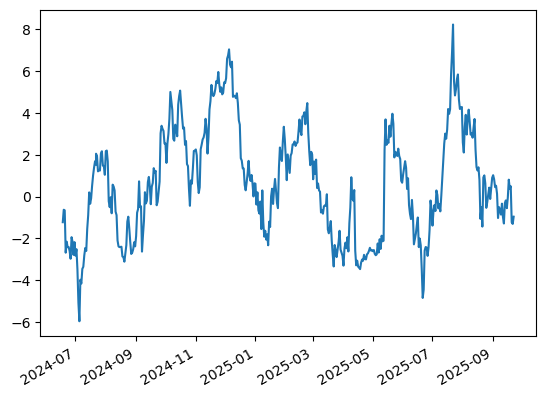

In [92]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [93]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.7222438212200616

## Risk Contribution

In [95]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,36.7830,0.8894,0.8165,0.0729
TRXUSDT,3.9969,0.1106,0.0378,0.0729
Portfolio,40.7799,1.0000,0.8543,0.1457


In [ ]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

In [97]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
TRXUSDT,10.631072,0.546905,0.386467,0.160439
BTCUSDT,0.246003,0.363863,0.194021,0.169842
OMUSDT,-2.577804,0.089232,0.026531,0.062701
Portfolio,8.299271,1.000000,0.607018,0.392982


# Value At Risk

## Historical

### Optimal Weights

In [101]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.0422705888826576, -0.04531111770418564)

### Current Weights

In [103]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.03283347456807952, -0.03945691721436294)

In [104]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [105]:
var=historical_var.iloc[row]
var

TRXUSDT     -0.024215
BTCUSDT     -0.006485
OMUSDT      -0.002700
ETHUSDT     -0.000000
SOLUSDT     -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT     0.000000
Portfolio   -0.033399
Name: 2025-06-11 00:00:00, dtype: float64

In [106]:
cvar=historical_var.iloc[:row+1].mean()
cvar

TRXUSDT     -0.026814
BTCUSDT     -0.009831
OMUSDT      -0.002812
ETHUSDT      0.000000
SOLUSDT      0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.039457
dtype: float64

## Parametric

### Optimal Weights

In [109]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.04231254116583531, -0.05240685013712543)

### Current Weights

In [111]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.035180909737785114, -0.04357385809303574)

## Multivariate

### Optimal Weights

In [114]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.03990445763038439, -0.046075456848929656)

### Current Weights

In [116]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.03495184383612347, -0.040028243803387056)

In [117]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

TRXUSDT     -0.016643
BTCUSDT     -0.013867
OMUSDT      -0.003909
Portfolio   -0.034419
dtype: float64

In [118]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

TRXUSDT     -0.017081
BTCUSDT     -0.013790
OMUSDT      -0.003992
Portfolio   -0.034862
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [122]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03985958391771882, -0.04617361898824945)

### Current Weights

In [124]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03484136680950581, -0.04074905307734486)

In [125]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [128]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.038753622790591906, -0.0441963979645032)

### Current Weights

In [130]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03522591694655513, -0.04285008318522197)

In [131]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [134]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0974325772188379, -0.12109145362638682)

### Current Weights

In [136]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06590376230929322, -0.08055310254898024)

In [137]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [140]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [141]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.04181763715400458, -0.04885255485610072)

### Current Weights

In [143]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03507708607263426, -0.04013443734255567)

In [144]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [145]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
TRXUSDT,-0.026048,-0.018284,-0.013029,-0.016643,-0.019137
BTCUSDT,-0.013191,-0.012753,-0.009512,-0.013867,-0.013363
OMUSDT,-0.001905,-0.003449,-0.002507,-0.003909,-0.003482
Portfolio,-0.041144,-0.034486,-0.025049,-0.034419,-0.035982


In [146]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
TRXUSDT,-0.026927,-0.018878,-0.013590,-0.017081,-0.019323
BTCUSDT,-0.012645,-0.012769,-0.009314,-0.013790,-0.013727
OMUSDT,-0.002127,-0.003273,-0.002431,-0.003992,-0.003464
Portfolio,-0.041698,-0.034921,-0.025336,-0.034862,-0.036514


## VaR Violation

In [148]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.028740,-0.061587,-0.054824,-0.012507
2024-01-15,-0.028740,-0.063425,-0.056001,0.042254
2024-01-16,-0.028740,-0.062598,-0.055753,-0.006892
2024-01-17,-0.028740,-0.063302,-0.056042,-0.014343
2024-01-18,-0.028740,-0.062044,-0.054530,0.008830
...,...,...,...,...
2025-09-19,-0.040746,-0.048259,-0.044925,-0.001365
2025-09-20,-0.038411,-0.050007,-0.044483,0.048968
2025-09-21,-0.038411,-0.043179,-0.038147,0.000746
2025-09-22,-0.045542,-0.046817,-0.044445,-0.044761


In [149]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-15,-0.047138,-0.048039,-0.048069,-0.036443
2023-12-16,-0.047138,-0.048106,-0.045057,0.010557
2023-12-17,-0.047138,-0.048749,-0.047979,-0.013621
2023-12-18,-0.047138,-0.048848,-0.047753,0.007280
2023-12-19,-0.047138,-0.046294,-0.046779,-0.004583
...,...,...,...,...
2025-09-19,-0.027593,-0.034656,-0.032832,-0.017080
2025-09-20,-0.027593,-0.034437,-0.031457,0.004780
2025-09-21,-0.015871,-0.028691,-0.024591,-0.008445
2025-09-22,-0.020250,-0.026693,-0.026070,-0.020766


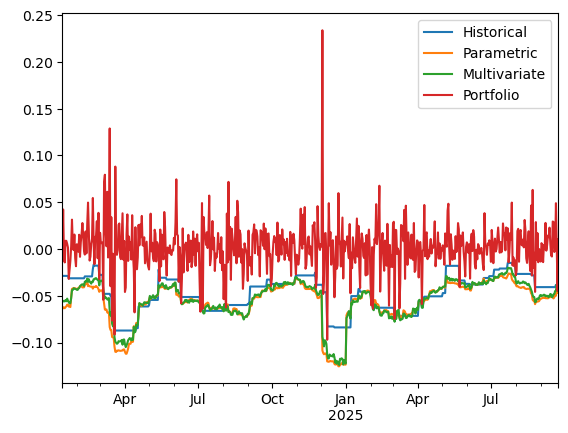

In [150]:
var_data.plot()
plt.show()

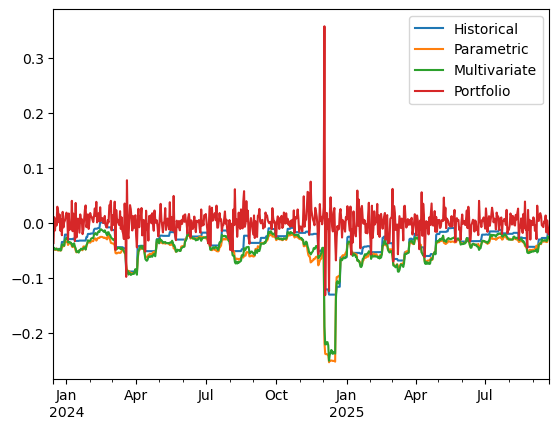

In [151]:
current_var_data.plot()
plt.show()


In [152]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.035541,0.009693,0.009693
Kupiec Stat,3.016987,31.256564,31.256564
P-value,0.082396,0.0,0.0


In [153]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.070878,0.009245,0.010786
Kupiec Stat,5.302564,33.763527,30.4633
P-value,0.021294,0.0,0.0


# Principal Component Analysis

## Historical PCA

In [156]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.86535967, 0.04205953, 0.03375558, 0.03124433, 0.02758089])

In [157]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.020080
ADAUSDT      0.018834
ALGOUSDT     0.022939
APTUSDT      0.019977
ARBUSDT      0.030283
ATOMUSDT     0.017990
AVAXUSDT     0.020688
BCHUSDT      0.010510
BNBUSDT      0.009293
BONKUSDT     0.028143
BTCUSDT      0.007155
CAKEUSDT     0.018181
CRVUSDT      0.023953
DOGEUSDT     0.023619
DOTUSDT      0.020020
ETCUSDT      0.019291
ETHUSDT      0.017739
FDUSDUSDT    0.000091
FETUSDT      0.022357
FILUSDT      0.020738
FLOKIUSDT    0.029374
GRTUSDT      0.022809
HBARUSDT     0.021636
ICPUSDT      0.020295
IMXUSDT      0.028680
INJUSDT      0.027424
LDOUSDT      0.027705
LINKUSDT     0.022867
LTCUSDT      0.015439
NEARUSDT     0.024022
NEXOUSDT     0.007386
OMUSDT       0.025293
OPUSDT       0.028385
PAXGUSDT    -0.000181
PEPEUSDT     0.026340
QNTUSDT      0.015034
RAYUSDT      0.024941
SEIUSDT      0.025520
SHIBUSDT     0.018615
SOLUSDT      0.019041
STXUSDT      0.022361
SUIUSDT      0.023712
TRXUSDT      0.005462
UNIUSDT      0.023421
USDCUSDT    -0.000010
VETUSDT   

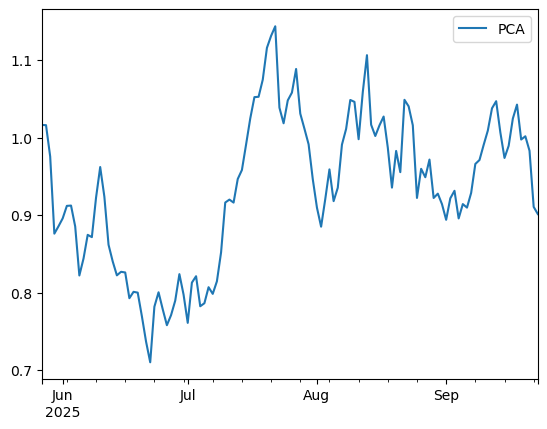

In [158]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

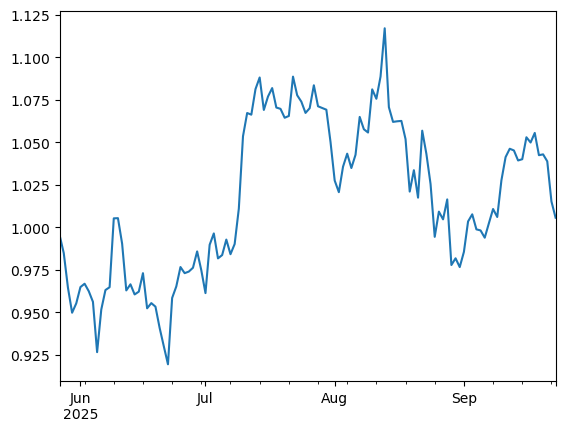

In [159]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [160]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
SHIBUSDT     0.124084
DOTUSDT      0.129380
FILUSDT      0.136259
VETUSDT      0.137071
ATOMUSDT     0.144245
GRTUSDT      0.151567
ICPUSDT      0.155987
NEARUSDT     0.158626
PEPEUSDT     0.186911
APTUSDT      0.187929
ADAUSDT      0.191866
STXUSDT      0.195810
DOGEUSDT     0.197535
ETHUSDT      0.199163
SOLUSDT      0.199659
ETCUSDT      0.200104
WBETHUSDT    0.200289
FETUSDT      0.202102
INJUSDT      0.224910
dtype: float64

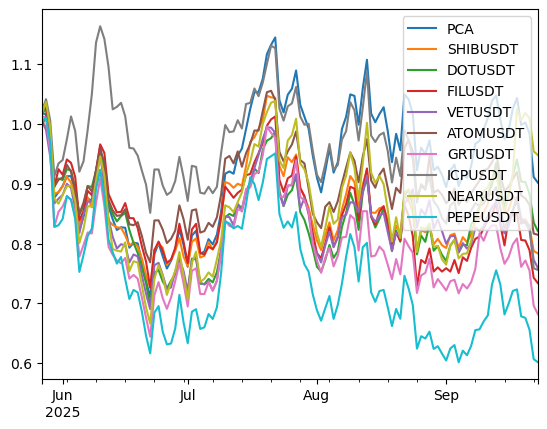

In [161]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

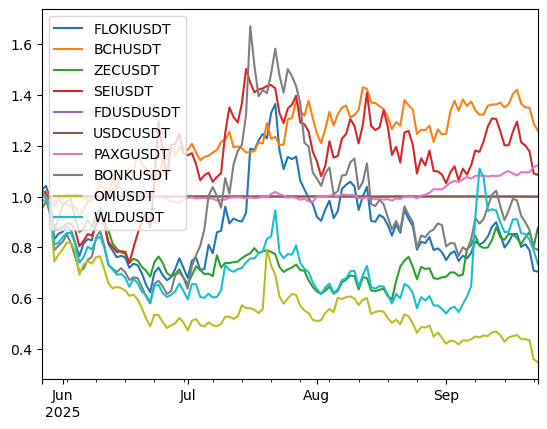

In [162]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [164]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.76392918, 0.15540319, 0.03515702, 0.02468745, 0.02082316])

In [165]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

TRXUSDT     0.042171
BTCUSDT     0.057657
OMUSDT      0.282507
ETHUSDT     0.150920
SOLUSDT     0.160149
BNBUSDT     0.081111
PEPEUSDT    0.227272
PAXGUSDT   -0.001786
Name: PC1, dtype: float64

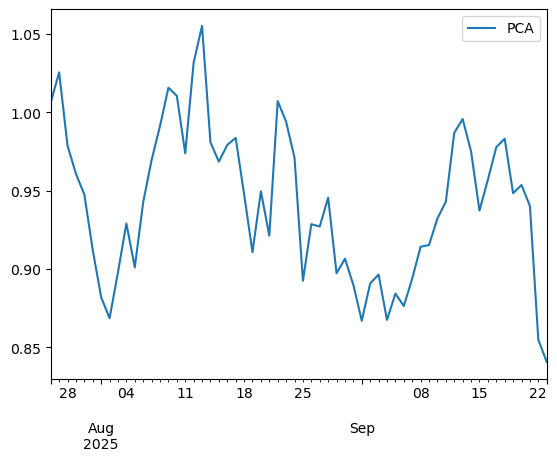

In [166]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

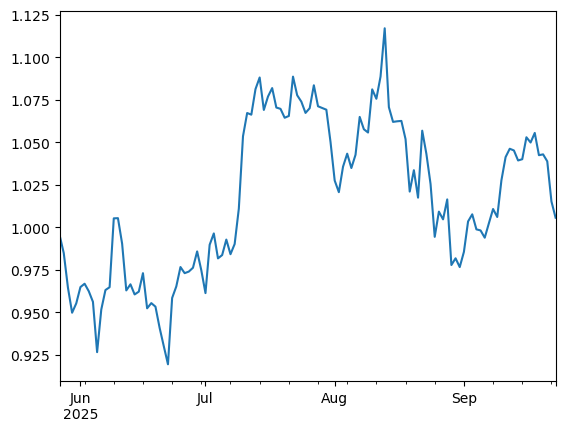

In [167]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [168]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA         0.000000
PEPEUSDT    0.214642
ETHUSDT     0.223103
SOLUSDT     0.231901
BNBUSDT     0.279315
BTCUSDT     0.306777
TRXUSDT     0.363526
OMUSDT      0.375255
PAXGUSDT    0.419485
dtype: float64

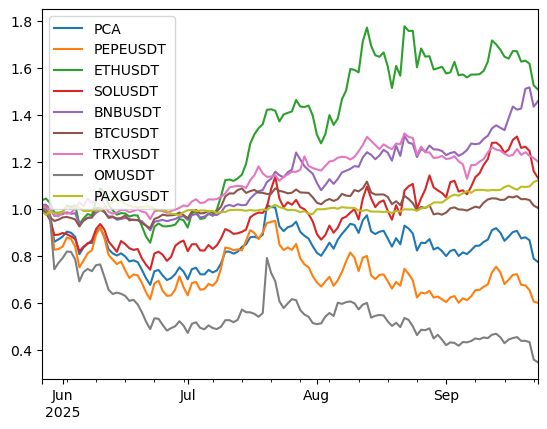

In [169]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [171]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT    1.926253
SOLUSDT     1.303018
ETHUSDT     1.110829
OMUSDT      1.022141
BTCUSDT     1.000000
BNBUSDT     0.673068
TRXUSDT     0.342499
PAXGUSDT    0.028583
Name: BTCUSDT, dtype: float64

In [172]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

OMUSDT      2.532370
SOLUSDT     2.217915
PEPEUSDT    2.166960
ETHUSDT     1.491790
BTCUSDT     1.000000
TRXUSDT     0.949545
BNBUSDT     0.945928
PAXGUSDT   -0.044900
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [174]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [175]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
PEPEUSDT,0.367148
BTCUSDT,0.330784
OMUSDT,0.139249
SOLUSDT,0.128597
ETHUSDT,0.091465
TRXUSDT,0.089267
BNBUSDT,0.078405
PAXGUSDT,0.057515


### Regression to PCA

In [177]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.4450464460648769

In [178]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

PCA         1.000000
ETHUSDT     0.903134
BNBUSDT     0.807070
BTCUSDT     0.744946
SOLUSDT     0.619928
PEPEUSDT    0.334278
TRXUSDT     0.275838
OMUSDT      0.154480
PAXGUSDT   -0.158530
dtype: float64

In [179]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT     2.055896
BNBUSDT     1.098191
ETHUSDT     1.037652
TRXUSDT     1.005698
PCA         1.000000
SOLUSDT     0.829805
PEPEUSDT    0.791941
OMUSDT      0.637337
PAXGUSDT   -0.728713
dtype: float64

### Correlation Matrix

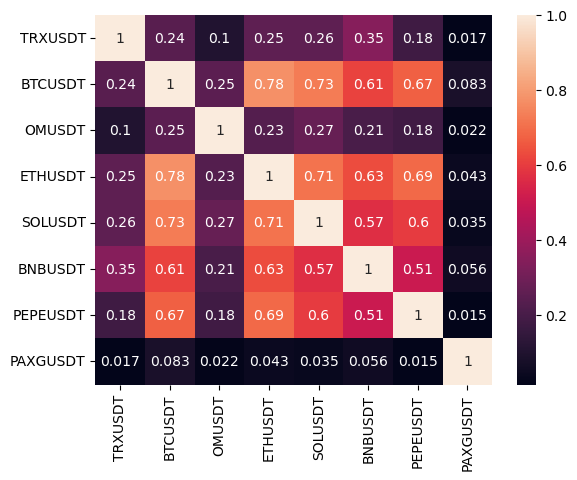

In [181]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

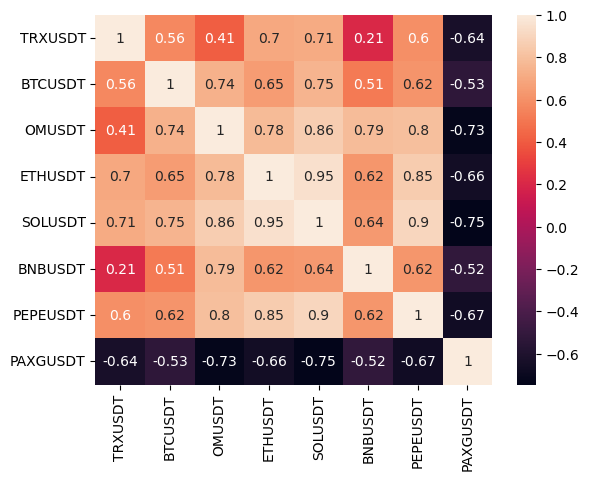

In [182]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [183]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [184]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

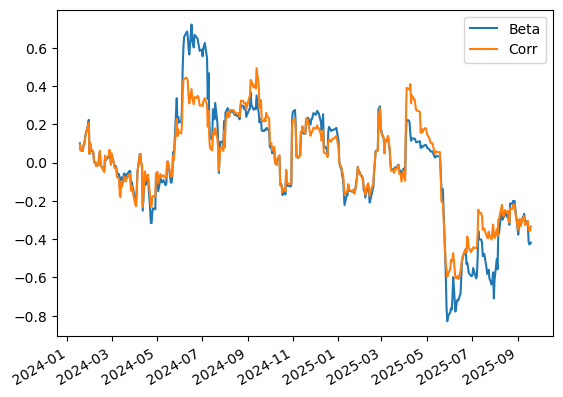

In [185]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [187]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,TRXUSDT,BTCUSDT,OMUSDT,ETHUSDT,SOLUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2023-12-14,0.000000,0.107613,0.104338,0.000000,0.000000,0.522522,0.000000,0.265527
2023-12-28,0.000000,0.000000,0.000000,0.000000,0.331762,0.668238,0.000000,0.000000
2024-01-11,0.000000,0.000000,0.560261,0.439739,0.000000,0.000000,0.000000,0.000000
2024-01-25,0.379492,0.000000,0.104622,0.000000,0.000000,0.000000,0.000000,0.515886
2024-02-08,0.066364,0.000000,0.047113,0.191144,0.041760,0.000000,0.000000,0.653620
2024-02-22,0.705974,0.000000,0.000000,0.164223,0.000000,0.129803,0.000000,0.000000
2024-03-07,0.000000,0.000000,0.000000,0.020832,0.156080,0.000000,0.046602,0.776486
2024-03-21,0.000000,0.000000,0.462471,0.000000,0.000000,0.471815,0.065714,0.000000
2024-04-04,0.000000,0.000920,0.019296,0.000000,0.000000,0.113904,0.000000,0.865879
2024-04-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [188]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [189]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0},
                                                                    {'type': 'eq', 'fun': lambda weights: weights[limit[1]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,ZECUSDT
2025-02-15,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2025-03-17,0.000000,0.98616,0.013840,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2025-04-16,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.727309,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2025-05-16,0.077176,0.00000,0.007009,0.0,0.0,0.0,0.000000,0.000000,0.027874,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.007493,0.000000,0.0,0.050893
2025-06-15,0.138296,0.00000,0.015918,0.0,0.0,0.0,0.000000,0.546743,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2025-07-15,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.236975,0.000000,0.276214,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.288125,0.0,0.000000
2025-08-14,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.224969,0.000000,...,0.557398,0.0,0.0,0.0,0.217633,0.0,0.000000,0.000000,0.0,0.000000
2025-09-13,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.129309,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.118374,0.000000,0.0,0.611565
2025-09-23,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.462440,0.000000,0.537560,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [190]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

ZECUSDT     0.611565
SOLUSDT     0.140752
AVAXUSDT    0.129309
WLDUSDT     0.118374
NEARUSDT    0.000000
NEXOUSDT    0.000000
Name: 2025-09-13 00:00:00, dtype: float64

In [191]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
